In [49]:
import pandas as pd
import numpy as np
import os

import missingno as ms
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import seaborn as sns

from ipywidgets import widgets
from ipywidgets import interactive

In [50]:
data1 = pd.read_csv('../dataset/Regular_Season_Batter.csv', index_col=0)
data2 = pd.read_csv('../dataset/Regular_Season_Batter_Day_by_Day.csv', index_col=0)
data3 = pd.read_csv('../dataset/Pre_Season_Batter.csv', index_col=0)
data4 = pd.read_csv('../dataset/submission.csv')

In [51]:
print('data1.shape: ',data1.shape)
print('data2.shape: ',data2.shape)
print('data3.shape: ',data3.shape)
print('data4.shape: ',data4.shape)

data1.shape:  (2454, 28)
data2.shape:  (109771, 19)
data3.shape:  (1393, 28)
data4.shape:  (220, 2)


In [52]:
def preprocessing_data(data):
    data['height'] = data['height/weight'].apply(lambda x: np.nan if str(x) == 'nan' else x.split('/')[0][:3]).astype(float)
    data['weight'] = data['height/weight'].apply(lambda x: np.nan if str(x) == 'nan' else x.split('/')[1][:-2]).astype(float)
    data['age'] = data.year - data.year_born.apply(lambda x: int(x[:4]))
    
    return data

## 범주형자료
- year
    - 시즌별 중간에 쉰 횟수 (부상의 가능성이 있을 수 있다.)
- team
- position


## 연속형자료
- 나머지

# train set, validation set, test set
- train set
    - 1995~2017년까지의 data
- validation set
    - 2018년까지의 data
- test set
    - 2019년 선수별 성적

# OPS ( OBP + SLG )
## OBP (출루율)
- https://ko.wikipedia.org/wiki/%EC%B6%9C%EB%A3%A8%EC%9C%A8
- 여기서 데이터에 없는건 희생플라이(SF)
- 공식 : (안타+볼넷+몸에 맞은 공) / (타수+볼넷+몸에 맞은 공+희생플라이)
## SLG (장타율)
- https://ko.wikipedia.org/wiki/%EC%9E%A5%ED%83%80%EC%9C%A8
- 공식 : (단타 수 + 2루타 수 x 2 + 3루타 수 x 3 + 홈런 수 x 4)/타수

# Regular_Season_Batter

In [53]:
data1 = preprocessing_data(data1)

In [54]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2454 entries, 0 to 344
Data columns (total 31 columns):
batter_name        2454 non-null object
year               2454 non-null int64
team               2454 non-null object
avg                2428 non-null float64
G                  2454 non-null int64
AB                 2454 non-null int64
R                  2454 non-null int64
H                  2454 non-null int64
2B                 2454 non-null int64
3B                 2454 non-null int64
HR                 2454 non-null int64
TB                 2454 non-null int64
RBI                2454 non-null int64
SB                 2454 non-null int64
CS                 2454 non-null int64
BB                 2454 non-null int64
HBP                2454 non-null int64
SO                 2454 non-null int64
GDP                2454 non-null int64
SLG                2428 non-null float64
OBP                2430 non-null float64
E                  2454 non-null int64
height/weight      1652 non-

In [5]:
data1.head()

,batter_name,year,team,avg,G,AB,R,H,2B,3B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
batter_id,,,,,,,,,,,,,,,,,,,,,
0,가르시아,2018,LG,0.339,50,183,27,62,9,0,...,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,강경학,2011,한화,0.000,2,1,0,0,0,0,...,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
1,강경학,2014,한화,0.221,41,86,11,19,2,3,...,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
1,강경학,2015,한화,0.257,120,311,50,80,7,4,...,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
1,강경학,2016,한화,0.158,46,101,16,16,3,2,...,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489


## Year

In [6]:
data1.year = data1.year.astype(str)

In [7]:
data1.year.unique()

array(['2018', '2011', '2014', '2015', '2016', '2017', '2013', '2005',
       '2006', '2007', '2008', '2012', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2009', '2010', '1996', '1993',
       '1994', '1995'], dtype=object)

## 아이디별 평균 OPS 

In [8]:
mean_ops_by_name = data1.groupby('batter_name').mean()['OPS']

In [9]:
mean_ops_by_name[mean_ops_by_name.isnull() == True]

batter_name
최민구   NaN
Name: OPS, dtype: float64

In [10]:
data1[data1.batter_name=='최민구']

,batter_name,year,team,avg,G,AB,R,H,2B,3B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
batter_id,,,,,,,,,,,,,,,,,,,,,
305,최민구,2015,삼성,NaN,6,0,1,0,0,0,...,0,NaN,NaN,0,NaN,1992년 03월 17일,NaN,칠성초-대구중-대구상원고-영남대,NaN,NaN


In [11]:
mean_ops_by_name = mean_ops_by_name.fillna(0)

In [12]:
mean_ops_by_name.describe()

count    345.000000
mean       0.615126
std        0.193352
min        0.000000
25%        0.506600
50%        0.625736
75%        0.737400
max        1.173719
Name: OPS, dtype: float64

C:\Users\wogur\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


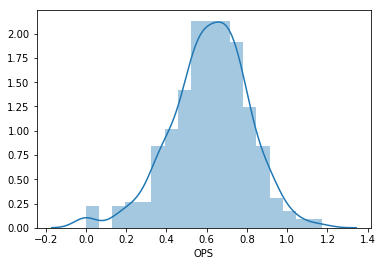

In [13]:
sns.distplot(mean_ops_by_name)

## 시즌 참가 횟수

In [14]:
pd.Series(data1.batter_name.value_counts()).describe()

count    345.000000
mean       7.113043
std        4.999009
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       20.000000
Name: batter_name, dtype: float64

C:\Users\wogur\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


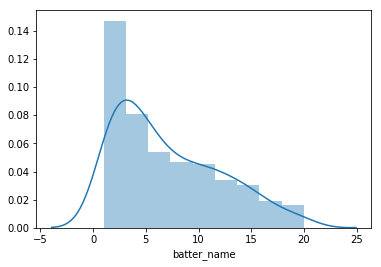

In [15]:
sns.distplot(data1.batter_name.value_counts())

## Team별 선수는 몇명?

In [16]:
data1.team.unique()

array(['LG', '한화', 'NC', 'OB', '삼성', '롯데', 'KT', '현대', '우리', '히어로즈', '넥센',
       '두산', 'SK', 'KIA', '해태', '쌍방울'], dtype=object)

In [17]:
old_level = ['한화','삼성','롯데','현대','우리','히어로즈','넥센','두산','해태','쌍방울']
new_level = ['Hanhwa','Samsung','Lotte','Hyundai','Wori','Heros','Nexen','Doosan','Hete','Ssang']

In [18]:
data1.team = data1.team.apply(lambda x: new_level[old_level.index(x)] if x in old_level else x)

In [19]:
team_df = data1.groupby(['team','batter_id']).count()['batter_name'].reset_index()
batter_by_team = team_df.groupby('team').count().reset_index().sort_values(by='batter_name')
batter_by_team.describe()

,batter_id,batter_name
count,16.000000,16.000000
mean,34.875000,34.875000
std,22.916879,22.916879
min,1.000000,1.000000
25%,13.000000,13.000000
50%,43.500000,43.500000
75%,53.250000,53.250000
max,64.000000,64.000000


In [20]:
batter_by_team

,team,batter_id,batter_name
14,Ssang,1,1
11,OB,2,2
3,Hete,3,3
2,Heros,13,13
15,Wori,13,13
4,Hyundai,15,15
6,KT,36,36
9,NC,40,40
12,SK,47,47
10,Nexen,49,49


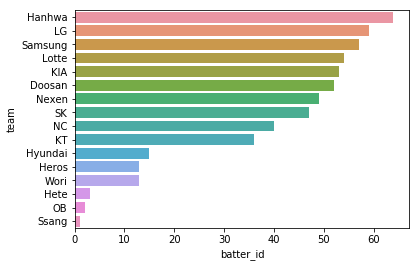

In [21]:
f = sns.barplot(y='team',x='batter_id',data=batter_by_team.sort_values(by='batter_id',ascending=False))

In [22]:
con_df_mean = data1.groupby('batter_name').mean().reset_index()
con_df_mean.describe()

,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,344.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,344.000000,344.000000,345.000000,344.000000
mean,0.226043,61.929316,164.917701,25.371223,45.646600,8.286882,0.822853,4.846585,70.118942,23.240466,4.270717,1.896223,16.491571,2.792703,33.673173,3.545309,0.325933,0.291806,3.130870,0.616914
std,0.070725,35.284855,138.061920,24.393928,42.453911,8.349866,1.147987,7.228496,70.737058,25.248798,6.212515,2.217842,16.551253,2.925591,27.087792,3.310275,0.120263,0.079511,3.473970,0.190756
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.184450,32.600000,44.428571,6.000000,9.166667,1.500000,0.000000,0.333333,13.000000,4.000000,0.400000,0.250000,3.454545,0.500000,11.500000,1.000000,0.255875,0.252000,0.727273,0.507275
50%,0.233000,60.800000,129.000000,18.333333,33.500000,5.600000,0.500000,2.000000,47.000000,14.750000,1.666667,1.071429,11.555556,2.000000,28.000000,2.625000,0.324972,0.303750,1.909091,0.626243
75%,0.276292,89.833333,244.833333,35.571429,67.400000,12.705882,1.125000,6.058824,106.384615,36.416667,5.333333,2.722222,23.600000,4.000000,47.750000,5.500000,0.402063,0.344239,4.200000,0.738300
max,0.500000,142.000000,535.000000,122.000000,171.000000,47.000000,8.250000,41.333333,324.666667,127.333333,37.333333,11.062500,94.500000,16.142857,139.000000,15.500000,0.767000,0.500000,25.000000,1.173719


## Correlation

In [103]:
data1.year = data1.year.astype(int)

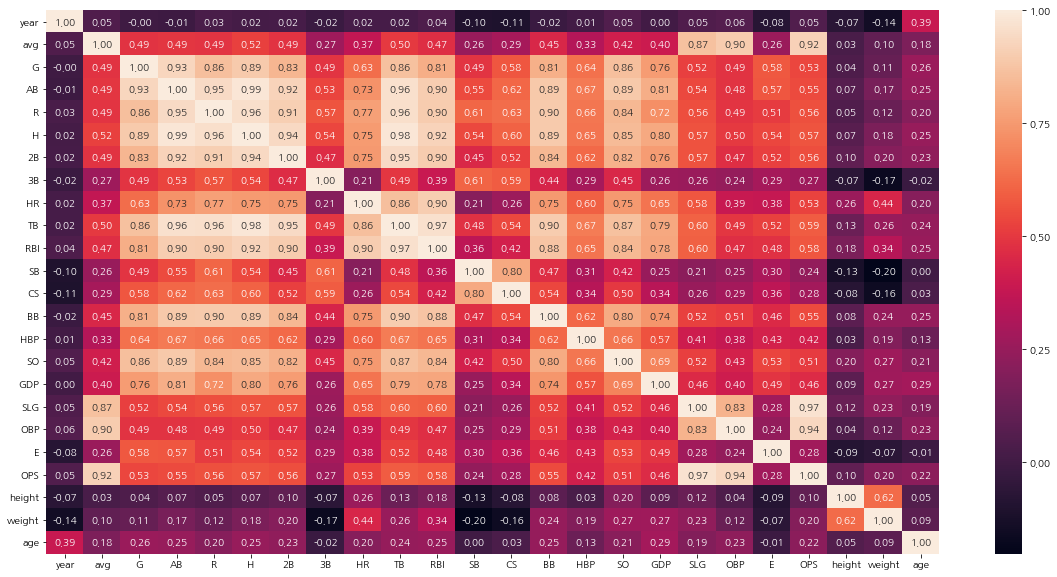

In [55]:
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(data1.iloc[:,1:].corr(), annot=True, fmt=".2f", ax=ax)
plt.show()

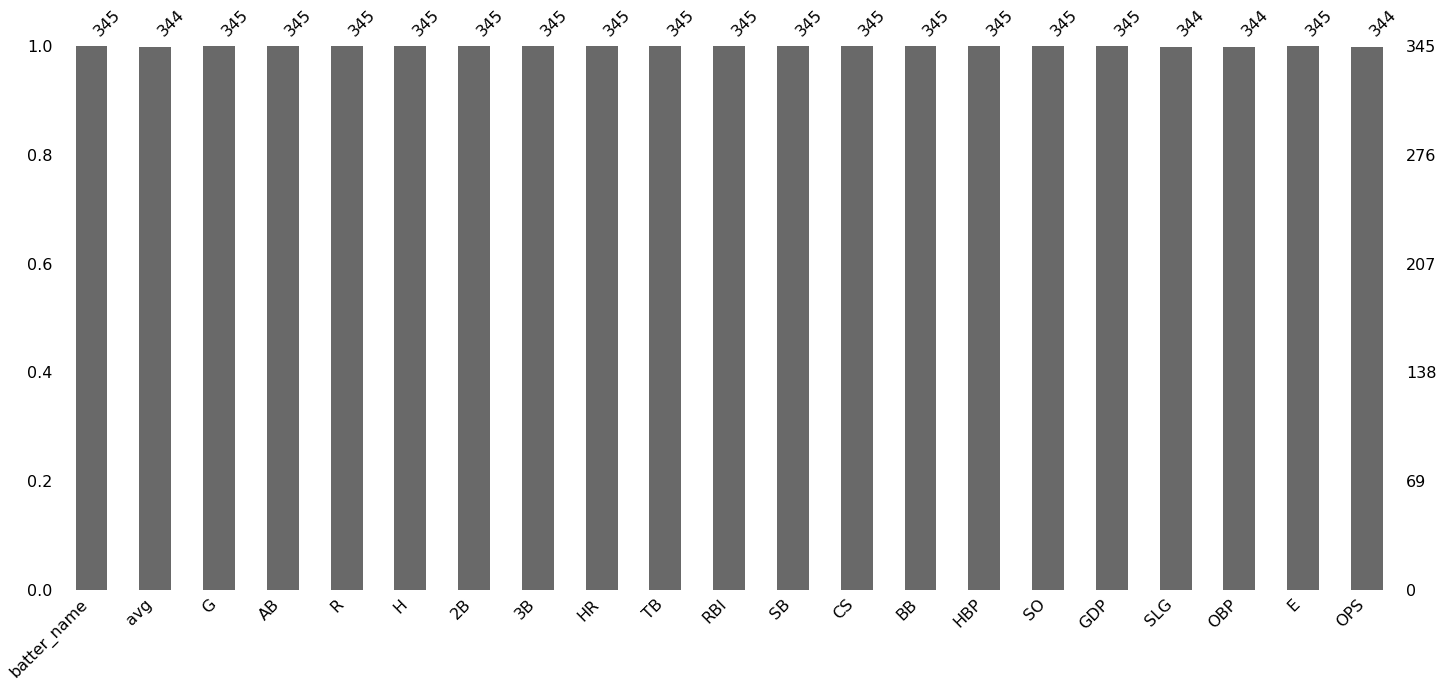

In [24]:
ms.bar(con_df_mean)

In [25]:
con_df_mean = con_df_mean.fillna(0)

C:\Users\wogur\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


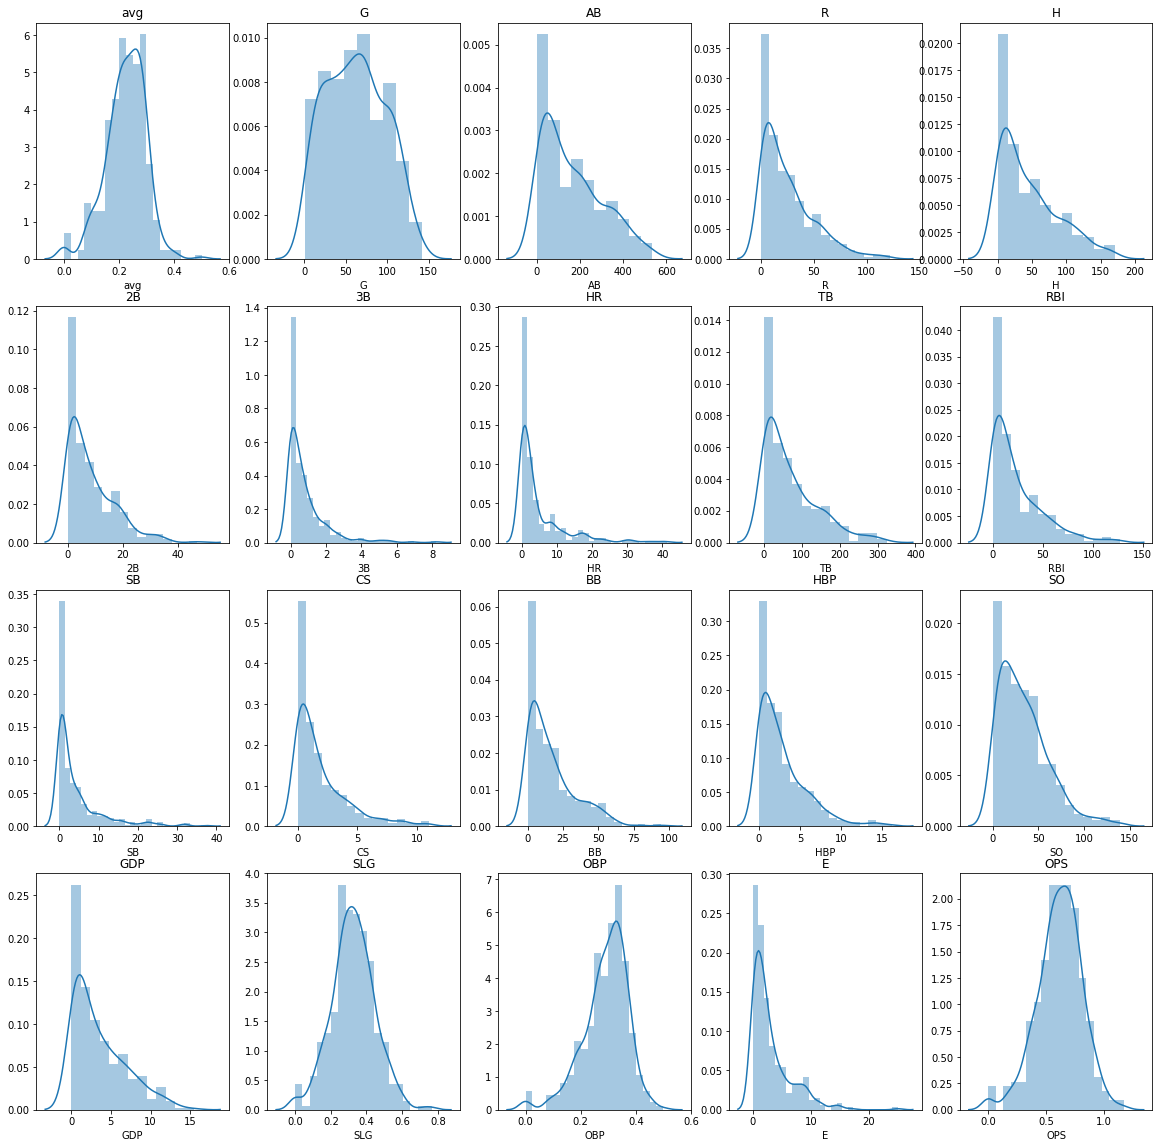

In [26]:
f, ax = plt.subplots(4,5, figsize=(20,20))
for i in range(4*5):
    sns.distplot(con_df_mean.iloc[:,i+1], ax=ax[i//5, i%5])
    ax[i//5, i%5].set_title(con_df_mean.columns[i+1])

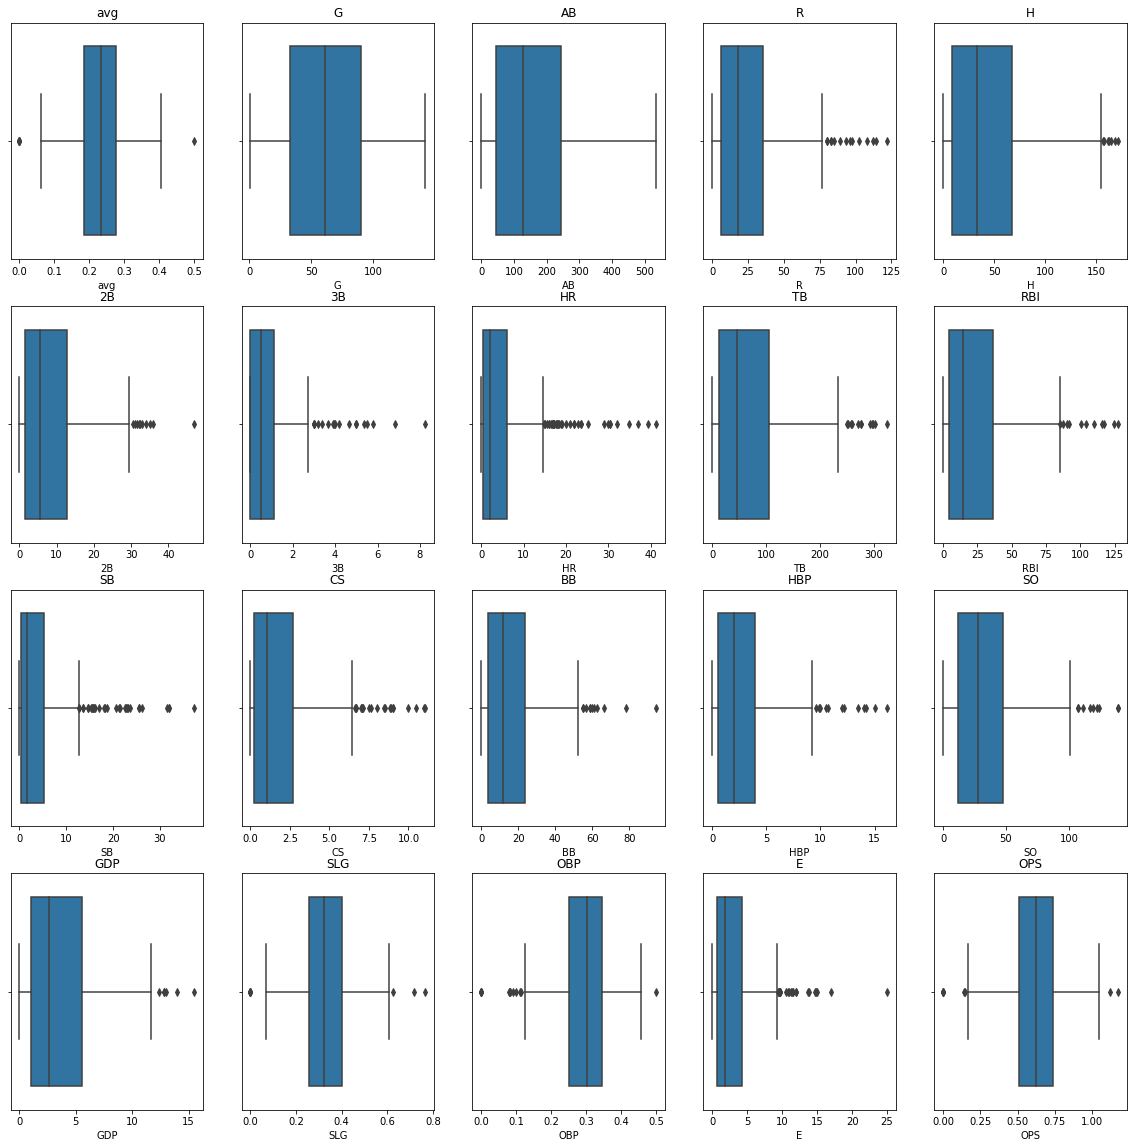

In [27]:
f, ax = plt.subplots(4,5, figsize=(20,20))
for i in range(4*5):
    sns.boxplot(con_df_mean.iloc[:,i+1], ax=ax[i//5, i%5])
    ax[i//5, i%5].set_title(con_df_mean.columns[i+1])

# Regular_Season_Batter_Day_by_Day

In [28]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109771 entries, 0 to 332
Data columns (total 19 columns):
batter_name      109771 non-null object
date             109771 non-null float64
opposing_team    109771 non-null object
avg1             109771 non-null object
AB               109771 non-null int64
R                109771 non-null int64
H                109771 non-null int64
2B               109771 non-null int64
3B               109771 non-null int64
HR               109771 non-null int64
RBI              109771 non-null int64
SB               109771 non-null int64
CS               109771 non-null int64
BB               109771 non-null int64
HBP              109771 non-null int64
SO               109771 non-null int64
GDP              109771 non-null int64
avg2             109771 non-null float64
year             109771 non-null int64
dtypes: float64(2), int64(14), object(3)
memory usage: 16.7+ MB


## avg1
- '-' 값이 있어서 모두 0.0으로 바꿔줌

In [58]:
data2.avg1 = data2.avg1.apply(lambda x: 0.0 if x=='-' else x).astype(float)

## date

In [59]:
def date2str(x):
    lst = str(x).split('.')
    if len(lst[0])==1:
        lst[0] = '0' + str(lst[0])
    if len(lst[1])==1:
        lst[1] = str(lst[1]) + '0'
    data = ''.join(lst)
    return data
date = data2.year.astype(str) + pd.Series(list(map(date2str, data2.date)), index=data2.index)
data2['fulldate'] = date

In [60]:
data2.fulldate.head()

batter_id
0    20180324
0    20180325
0    20180327
0    20180328
0    20180329
Name: fulldate, dtype: object

In [62]:
data2.fulldate.unique()

array(['20180324', '20180325', '20180327', ..., '20010807', '20010906',
       '20030901'], dtype=object)

## year
- 정규 시즌은 95년도부터 있는데 정규시즌의 일자별 데이터는 2001년부터 있다. 
- 일자별 데이터를 활용하기 위해서는 95년도부터의 자료를 사용하는것이 좋다. 
- 결과는 더 좋아지긴했다. 

In [64]:
data2.year.unique()

array([2018, 2011, 2014, 2015, 2016, 2017, 2013, 2006, 2007, 2008, 2009,
       2010, 2004, 2005, 2012, 2002, 2003, 2001], dtype=int64)

In [65]:
data1.year.unique()

array([2018, 2011, 2014, 2015, 2016, 2017, 2013, 2005, 2006, 2007, 2008,
       2012, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2009, 2010,
       1996, 1993, 1994, 1995], dtype=int64)

## 시즌별 최대연속경기 출장
- 정규리그 일자별 데이터는 선수의 팀정보가 없기 때문에 정규시즌 데이터에서 가져와야한다.

In [66]:
data2 = pd.merge(data1[['batter_name','year','team']], data2, on=['batter_name','year'], how='right')

In [72]:
teams = data2.team.unique()
team_by_games = dict()
for team in teams:
    years = data2[data2.team==team].year.unique()
    team_by_games[team] = dict()
    for year in years:
        team_by_games[team][year] = data2[(data2.team==team) & (data2.year==year)].date.unique().shape[0]

In [73]:
team_by_games

{'LG': {2018: 144,
  2016: 144,
  2017: 144,
  2010: 133,
  2013: 128,
  2014: 128,
  2015: 146,
  2008: 126,
  2012: 133,
  2011: 133,
  2003: 119,
  2004: 128,
  2005: 126,
  2006: 125,
  2007: 126,
  2009: 131,
  2002: 107},
 '한화': {2011: 131,
  2014: 128,
  2015: 145,
  2016: 144,
  2017: 144,
  2018: 144,
  2001: 85,
  2002: 99,
  2003: 123,
  2004: 128,
  2005: 124,
  2006: 125,
  2007: 124,
  2008: 126,
  2009: 130,
  2012: 133,
  2013: 128,
  2010: 133},
 'NC': {2013: 129, 2015: 144, 2016: 143, 2017: 144, 2018: 144, 2014: 128},
 '롯데': {2004: 124,
  2005: 126,
  2006: 123,
  2007: 126,
  2008: 126,
  2009: 132,
  2010: 136,
  2011: 133,
  2012: 132,
  2013: 128,
  2014: 128,
  2015: 144,
  2016: 145,
  2017: 144,
  2018: 143,
  2002: 66,
  2003: 86,
  2001: 6},
 '삼성': {2018: 144,
  2017: 144,
  2015: 144,
  2016: 143,
  2007: 126,
  2012: 133,
  2013: 128,
  2009: 131,
  2010: 133,
  2011: 133,
  2014: 128,
  2004: 128,
  2005: 126,
  2008: 126,
  2001: 125,
  2002: 126,
  2003:

# Pre_Season_Batter

## team

In [32]:
data3.team.unique()

array(['LG', '한화', 'NC', '넥센', '롯데', '삼성', 'KT', 'SK', 'KIA', '두산',
       '히어로즈', '우리', '현대'], dtype=object)

In [33]:
old_level = ['한화','삼성','롯데','현대','우리','히어로즈','넥센','두산','해태','쌍방울']
new_level = ['Hanhwa','Samsung','Lotte','Hyundai','Wori','Heros','Nexen','Doosan','Hete','Ssang']

In [34]:
data3.team = data3.team.apply(lambda x: new_level[old_level.index(x)] if x in old_level else x)

# 선수별

In [74]:
def ops_by_name(name):    
    i = 0
    if name in data1.batter_name.unique():
        regular = data1[data1['batter_name']==name]
#         regular_day = data2[data2['batter_name']==name]
        i += 1
    else:
        print('정규시즌 참여 기록 없음')
    
    if name in data3.batter_name.unique():
        pre = data3[data3['batter_name']==name]
        i += 1
    else:
        print('이전시즌 참여 기록 없음')
        
    f, ax = plt.subplots(i,1, figsize=(15,10))
    if i == 1 : 
        ax[0].plot(regular.year, regular.OPS, 'r', marker='o', label='OPS')
        ax[0].plot(regular.year, regular.SLG, 'b', marker='o', label='SLG')
        ax[0].plot(regular.year, regular.OBP, 'g', marker='o', label='OBP')
        ax[0].legend(loc='upper right')
#         ax[1].plot('fulldate', 'avg1', 'r',data=regular_day)
#         ax[1].set_xticklabels(regular_day.fulldate, rotation=30)
#         ax1_2 = ax[1].twinx()
#         ax1_2.plot('fulldate', 'avg2', 'b',data=regular_day)
        plt.show()
    else:
        ax[0].plot(regular.year, regular.OPS, 'r', marker='o', label='OPS')
        ax[0].plot(regular.year, regular.SLG, 'b', marker='o', label='SLG')
        ax[0].plot(regular.year, regular.OBP, 'g', marker='o', label='OBP')
        ax[0].legend(loc='upper right')
#         ax[1].plot('fulldate', 'avg1', 'r',data=regular_day)
#         ax[1].set_xticklabels(regular_day.fulldate, rotation=30)
#         ax1_2 = ax[1].twinx()
#         ax1_2.plot('fulldate', 'avg2', 'b',data=regular_day)
        sns.lineplot(x='year', y='OPS', linestyle='-', marker='o', data=pre, ax=ax[1])
        plt.show()

In [75]:
names = set(np.concatenate([data1.batter_name.unique(), data2.batter_name.unique(), data3.batter_name.unique()], axis=0))
len(names)

345

In [79]:
data1

,batter_name,year,team,avg,G,AB,R,H,2B,3B,...,E,height/weight,year_born,position,career,starting_salary,OPS,height,weight,age
batter_id,,,,,,,,,,,,,,,,,,,,,
0,가르시아,2018,LG,0.339,50,183,27,62,9,0,...,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902000,177.0,93.0,33
1,강경학,2011,한화,0.000,2,1,0,0,0,0,...,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000000,180.0,72.0,19
1,강경학,2014,한화,0.221,41,86,11,19,2,3,...,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686000,180.0,72.0,22
1,강경학,2015,한화,0.257,120,311,50,80,7,4,...,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673000,180.0,72.0,23
1,강경학,2016,한화,0.158,46,101,16,16,3,2,...,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489000,180.0,72.0,24
1,강경학,2017,한화,0.214,59,84,17,18,2,1,...,4,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.552000,180.0,72.0,25
1,강경학,2018,한화,0.278,77,245,42,68,11,1,...,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.774000,180.0,72.0,26
2,강구성,2013,NC,0.000,2,2,0,0,0,0,...,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.000000,180.0,82.0,20
2,강구성,2015,NC,0.200,4,5,0,1,1,0,...,0,180cm/82kg,1993년 06월 09일,외야수(우투좌타),관산초-부천중-야탑고-NC-상무,9000만원,0.600000,180.0,82.0,22


In [78]:
interactive(ops_by_name, name=names)

interactive(children=(Dropdown(description='name', options=('정진호', '전병우', '최선호', '김진곤', '고메즈', '김상수', '전현태', '…

# 팀별

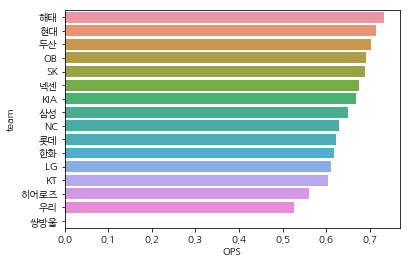

In [19]:
ops_team = data1.groupby('team').mean()['OPS'].reset_index().sort_values(by='OPS', ascending=False)
sns.barplot('OPS', 'team', data=ops_team)

In [77]:
data1_team = data1[['team','year','OPS']].groupby(['team','year']).mean().reset_index()
data3_team = data3[['team','year','OPS']].groupby(['team','year']).mean().reset_index()

In [84]:
data3[(data3['team'] == 'KIA') & (data3['year']==2004)][['team','year','OPS']]

,team,year,OPS
batter_id,,,
63,KIA,2004,0.0
145,KIA,2004,5.0


In [81]:
def ops_by_team(team):    
    regular = data1_team[data1_team['team']==team]
    pre = data3_team[data3_team['team']==team]
    f, ax = plt.subplots(2,1, figsize=(20,10))
    sns.lineplot(x='year', y='OPS', linestyle='-', marker='o', data=regular, ax=ax[0])
    sns.lineplot(x='year', y='OPS', linestyle='-', marker='o', data=pre, ax=ax[1])
    plt.show()

In [82]:
teams = set(np.concatenate([data1.team.unique(), data3.team.unique()], axis=0))
interactive(ops_by_team, team=teams)

interactive(children=(Dropdown(description='team', options=('KIA', 'Hyundai', 'Ssang', 'Heros', 'Nexen', 'Hanh…

# 포지션별

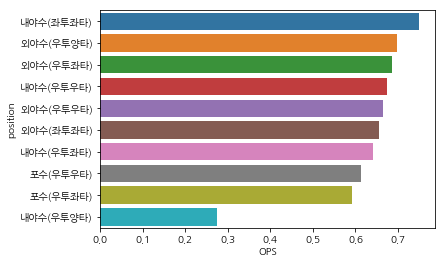

In [20]:
ops_position = data1.groupby('position').mean()['OPS'].reset_index().sort_values(by='OPS', ascending=False)
sns.barplot('OPS', 'position', data=ops_position)

In [21]:
data1_position = data1[['position','year','OPS']].groupby(['position','year']).mean().reset_index()
data3_position = data3[['position','year','OPS']].groupby(['position','year']).mean().reset_index()

In [22]:
def ops_by_position(position):    
    regular = data1_position[data1_position['position']==position]
    pre = data3_position[data3_position['position']==position]
    f, ax = plt.subplots(2,1, figsize=(20,10))
    sns.lineplot(x='year', y='OPS', linestyle='-', marker='o', data=regular, ax=ax[0])
    sns.lineplot(x='year', y='OPS', linestyle='-', marker='o', data=pre, ax=ax[1])
    plt.show()

In [35]:
positions = set(np.concatenate([data1.position.unique(), data3.position.unique()], axis=0))
positions.remove(np.nan)
interactive(ops_by_position, position=positions)

interactive(children=(Dropdown(description='position', options=('내야수(우투양타)', '포수(우투우타)', '외야수(우투우타)', '외야수(우투좌…

# 몸무게별 SLG, OBP 차이?

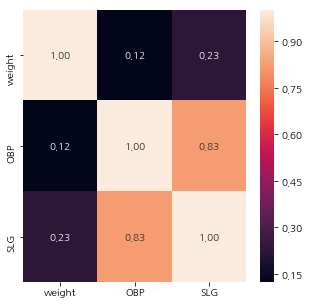

In [56]:
f, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(data1[['weight','OBP','SLG']].corr(), annot=True, fmt=".2f", ax=ax)